In [1]:
import darshan

#### Open Darshan log file and read in data

In [2]:
logfile = "example_logs/example.darshan"
# obtain a report object containing all data for the input log
report = darshan.DarshanReport(logfile, read_all=True)
# for reference, print all attributes associated with the report object
dir(report)

['__add__',
 '__class__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cleanup',
 '_counters',
 '_heatmaps',
 '_metadata',
 '_modules',
 '_mounts',
 'automatic_summary',
 'converted_records',
 'counters',
 'data',
 'data_revision',
 'dtype',
 'end_time',
 'filename',
 'heatmaps',
 'info',
 'log',
 'lookup_name_records',
 'metadata',
 'mod_read_all_apmpi_records',
 'mod_read_all_apxc_records',
 'mod_read_all_dxt_records',
 'mod_read_all_lustre_records',
 'mod_read_all_records',
 'mod_records',
 'modules',
 'mounts',
 'name_records',
 'open',
 'provenance_enabled',
 'provenance_graph',
 'provenance_reports',
 'read_all',
 'r

In [3]:
# quickly display some info about the log data
report.info()

Filename:       example_logs/example.darshan
Executable:     /global/project/projectdirs/m888/glock/tokio-abc-results/bin.edison/vpicio_uni /scratch2/scratchdirs/glock/tokioabc-s.4478544/vpicio/vpicio.hdf5 32
Times:          2017-03-20 04:07:47 to 2017-03-20 04:09:43
Run time:       117.0000 (s)
Processes:      2048
JobID:          4478544
UID:            69615
Modules in Log: ['POSIX', 'MPI-IO', 'LUSTRE', 'STDIO']
Loaded Records: {'POSIX': 1, 'MPI-IO': 1, 'STDIO': 129, 'LUSTRE': 1}
Name Records:   4
Darshan/Hints:  {'lib_ver': '3.1.3', 'h': 'romio_no_indep_rw=true;cb_nodes=4'}
DarshanReport:  id(140222677424160) (tmp)


#### Convert some record data to a DataFrame

In [4]:
# the log may contain data from multiple modules
report.modules

{'POSIX': {'len': 186,
  'ver': 3,
  'idx': 1,
  'partial_flag': False,
  'num_records': 1},
 'MPI-IO': {'len': 154,
  'ver': 2,
  'idx': 2,
  'partial_flag': False,
  'num_records': 1},
 'LUSTRE': {'len': 87,
  'ver': 1,
  'idx': 8,
  'partial_flag': False,
  'num_records': 1},
 'STDIO': {'len': 3234,
  'ver': 1,
  'idx': 9,
  'partial_flag': False,
  'num_records': 129}}

In [5]:
# we can extract data for a specific module (e.g., POSIX)
# in DataFrame format using the 'records' attribute and
# the 'to_df()' method
# NOTE: the returned type here is actually a dictionary, with
#       2 separate DataFrames: 'counters' (for integer record data)
#       and 'fcounters' (for floating point record data)
posix_recs = report.records['POSIX'].to_df()
print(posix_recs)

{'counters':    rank                   id  POSIX_OPENS  POSIX_FILENOS  POSIX_DUPS  \
0    -1  6301063301082038805         2049             -1          -1   

   POSIX_READS  POSIX_WRITES  POSIX_SEEKS  POSIX_STATS  POSIX_MMAPS  ...  \
0            0         16402        16404            0            0  ...   

   POSIX_ACCESS3_ACCESS  POSIX_ACCESS4_ACCESS  POSIX_ACCESS1_COUNT  \
0                   544                   328                16384   

   POSIX_ACCESS2_COUNT  POSIX_ACCESS3_COUNT  POSIX_ACCESS4_COUNT  \
0                    8                    2                    2   

   POSIX_FASTEST_RANK  POSIX_FASTEST_RANK_BYTES  POSIX_SLOWEST_RANK  \
0                 597                1073741824                1312   

   POSIX_SLOWEST_RANK_BYTES  
0                1073741824  

[1 rows x 71 columns], 'fcounters':    rank                   id  POSIX_F_OPEN_START_TIMESTAMP  \
0    -1  6301063301082038805                      3.919141   

   POSIX_F_READ_START_TIMESTAMP  POSIX_F_WRITE

#### Reproduce a job summary "operation counts" figure

TypeError: 'DarshanReport' object is not subscriptable

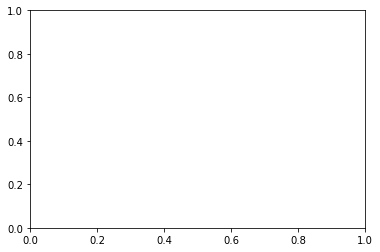

In [6]:
# import routine for plotting op counts and enable experimental mode
from darshan.experimental.plots import plot_opcounts
darshan.enable_experimental()

# this plotting routine expects some input about what data to plot
# (in this case, a report object and a module name)
plot_opcounts(report, "POSIX")

 As you can see above from the `plot_opcounts()` signature, it takes a single report object as input. Internally, this plotting routine has logic to combine all of the records in the report object to plot total number of operations across all file records.
 
 Since a report object corresponds to a single Darshan log, we can't use this function to plot
 data from multiple Darshan logs.

#### Darshan accumulator API

PyDarshan includes an "accumulator" API, which allows multiple records (perhaps coming from different log files) to be aggregated into a single "summary" record.

To resolve the plotting issue mentioned above, one option would be to update the plotting routine to take a single record as input (rather than a report object). We can ultimately use the "summary" record generated by the accumulator interface above as input to handle the use case where we want to plot data from multiple log files.

In [7]:
from darshan.backend.cffi_backend import accumulate_records

# accumulate all records in posix_recs, and then print out the "summary" record
acc = accumulate_records(posix_recs, "POSIX", report.metadata['job']['nprocs'])
# print(type(acc))
# print(type(acc.summary_record))
# print(acc.summary_record, end='\n\n\n\n')
print(acc.summary_record['counters'], end='\n\n\n\n')
# print(acc.summary_record['counters']["POSIX_OPENS"], end='\n\n\n\n')
# printint(dir(acc.summary_record))
# print(acc.summary_record.summary)



                    id  rank  POSIX_OPENS  POSIX_FILENOS  POSIX_DUPS  \
0  6301063301082038805    -1         2049             -1          -1   

   POSIX_READS  POSIX_WRITES  POSIX_SEEKS  POSIX_STATS  POSIX_MMAPS  ...  \
0            0         16402        16404            0            0  ...   

   POSIX_ACCESS3_ACCESS  POSIX_ACCESS4_ACCESS  POSIX_ACCESS1_COUNT  \
0                   544                   328                16384   

   POSIX_ACCESS2_COUNT  POSIX_ACCESS3_COUNT  POSIX_ACCESS4_COUNT  \
0                    8                    2                    2   

   POSIX_FASTEST_RANK  POSIX_FASTEST_RANK_BYTES  POSIX_SLOWEST_RANK  \
0                 597                1073741824                1312   

   POSIX_SLOWEST_RANK_BYTES  
0                1073741824  

[1 rows x 71 columns]





### <span style="color:red">First Step</span>

Our first step is to modify the plotting code `plot_opcounts()` (in file darshan/experimental/plots/plot_opcounts.py) to take a single record as input rather than a report object. Ultimately, we should be able to pass in the summary record from above and get an identical plot to the one generated previously in this notebook (i.e., based on the old code).

In [8]:
print(dir(acc))

['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'derived_metrics', 'index', 'summary_record']


In [9]:
print("acc: ", acc, end="\n\n\n\n")
print("acc.summary_record: ", acc.summary_record, end="\n\n\n\n")
print("acc.count: ", acc.count, end="\n\n\n\n")
print("acc.derived_metrics: ", acc.derived_metrics, end="\n\n\n\n")
print("acc.index: ", acc.index, end="\n\n\n\n")
print("acc.summary_record['counters']: ", acc.summary_record['counters'], end="\n\n\n\n")
print("acc.summary_record['counters']['POSIX_OPENS']: ", acc.summary_record['counters']["POSIX_OPENS"], end="\n\n")
print("acc.summary_record['counters']['POSIX_OPENS'][0]: ", acc.summary_record['counters']["POSIX_OPENS"][0])

acc:  AccumulatedRecords(derived_metrics=<cdata 'struct darshan_derived_metrics *' owning 512 bytes>, summary_record={'id': 6301063301082038805, 'rank': -1, 'counters':                     id  rank  POSIX_OPENS  POSIX_FILENOS  POSIX_DUPS  \
0  6301063301082038805    -1         2049             -1          -1   

   POSIX_READS  POSIX_WRITES  POSIX_SEEKS  POSIX_STATS  POSIX_MMAPS  ...  \
0            0         16402        16404            0            0  ...   

   POSIX_ACCESS3_ACCESS  POSIX_ACCESS4_ACCESS  POSIX_ACCESS1_COUNT  \
0                   544                   328                16384   

   POSIX_ACCESS2_COUNT  POSIX_ACCESS3_COUNT  POSIX_ACCESS4_COUNT  \
0                    8                    2                    2   

   POSIX_FASTEST_RANK  POSIX_FASTEST_RANK_BYTES  POSIX_SLOWEST_RANK  \
0                 597                1073741824                1312   

   POSIX_SLOWEST_RANK_BYTES  
0                1073741824  

[1 rows x 71 columns], 'fcounters':                

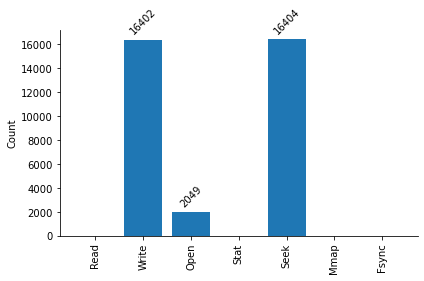

In [10]:
# Test for plot_opcounts POSIX
from darshan.experimental.plots import plot_opcounts
darshan.enable_experimental()
plot_opcounts(acc.summary_record, "POSIX")

-1


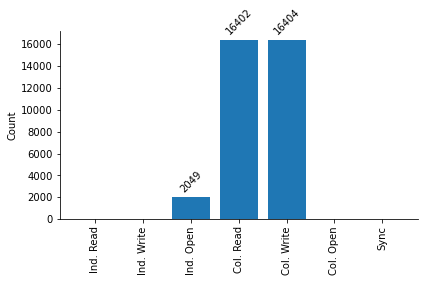

In [11]:
# Test for plot_opcounts MPI-IO
from darshan.experimental.plots import plot_opcounts
acc_MPIIO = accumulate_records(posix_recs, "MPI-IO", report.metadata['job']['nprocs'])
print(acc_MPIIO.summary_record['counters']["MPIIO_INDEP_READS"][0])
darshan.enable_experimental()
plot_opcounts(acc_MPIIO.summary_record, "MPI-IO")

-1


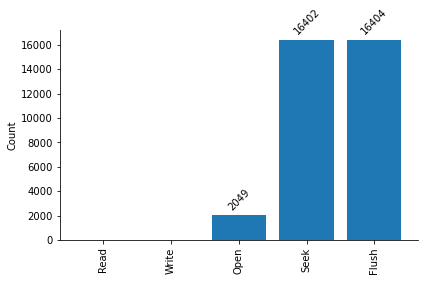

In [12]:
# Test for plot_opcounts STDIO
from darshan.experimental.plots import plot_opcounts
acc_STDIO = accumulate_records(posix_recs, "STDIO", report.metadata['job']['nprocs'])
print(acc_STDIO.summary_record['counters']["STDIO_READS"][0])
darshan.enable_experimental()
plot_opcounts(acc_STDIO.summary_record, "STDIO")

ValueError: Error: plot_opcounts not supported for module H5F

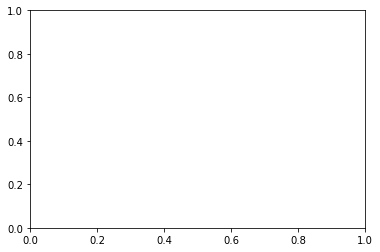

In [17]:
#Test for plot_opcounts H5F
from darshan.experimental.plots import plot_opcounts
# acc_H5F = accumulate_records(posix_recs, "H5F", report.metadata['job']['nprocs'])
# print(acc_H5F.summary_record['counters']["H5F_FLUSHES"][0])
darshan.enable_experimental()
plot_opcounts(report, "H5F")

ValueError: Error: plot_opcounts not supported for module PNETCDF_FILE

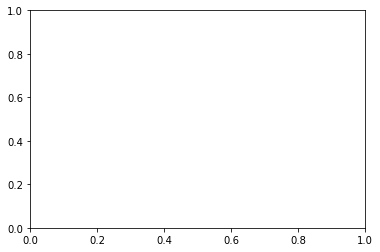

In [14]:
#Test for plot_opcounts PNETCDF_FILE
from darshan.experimental.plots import plot_opcounts
# acc_PNETCDF_FILE = accumulate_records(posix_recs, "PNETCDF_FILE", report.metadata['job']['nprocs'])
# print(acc_PNETCDF_FILE.summary_record['counters']["PNETCDF_FILE_SYNCS"][0])
# darshan.enable_experimental()
plot_opcounts(report, "PNETCDF_FILE")

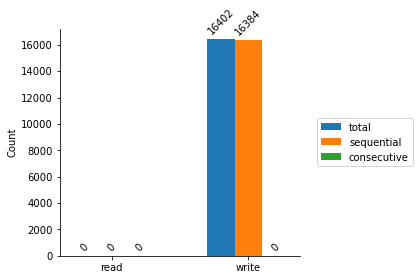

In [15]:
# Test for plot_posix_access_pattern
from darshan.experimental.plots import plot_posix_access_pattern
darshan.enable_experimental()
plot_posix_access_pattern(acc.summary_record)